In [4]:
%pip install wfdb

^C
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install missingno

Note: you may need to restart the kernel to use updated packages.


# 1. Environment Setup and Data Processing

### 1.1 Import libraries & signal data directory

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import pywt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = 'Desktop/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
sampling_rate=100

### 1.2 Metadata preprocessing

In [4]:
# load and convert annotation data
metadata = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
metadata.scp_codes = metadata.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_codes (diagnosis) for each signal data
scp_codes_df = metadata[['scp_codes']]
print(scp_codes_df)

                                                scp_codes
ecg_id                                                   
1                {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                            {'NORM': 80.0, 'SBRAD': 0.0}
3                              {'NORM': 100.0, 'SR': 0.0}
4                              {'NORM': 100.0, 'SR': 0.0}
5                              {'NORM': 100.0, 'SR': 0.0}
...                                                   ...
21833   {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834            {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                          {'ISCAS': 50.0, 'SR': 0.0}
21836                          {'NORM': 100.0, 'SR': 0.0}
21837                          {'NORM': 100.0, 'SR': 0.0}

[21799 rows x 1 columns]


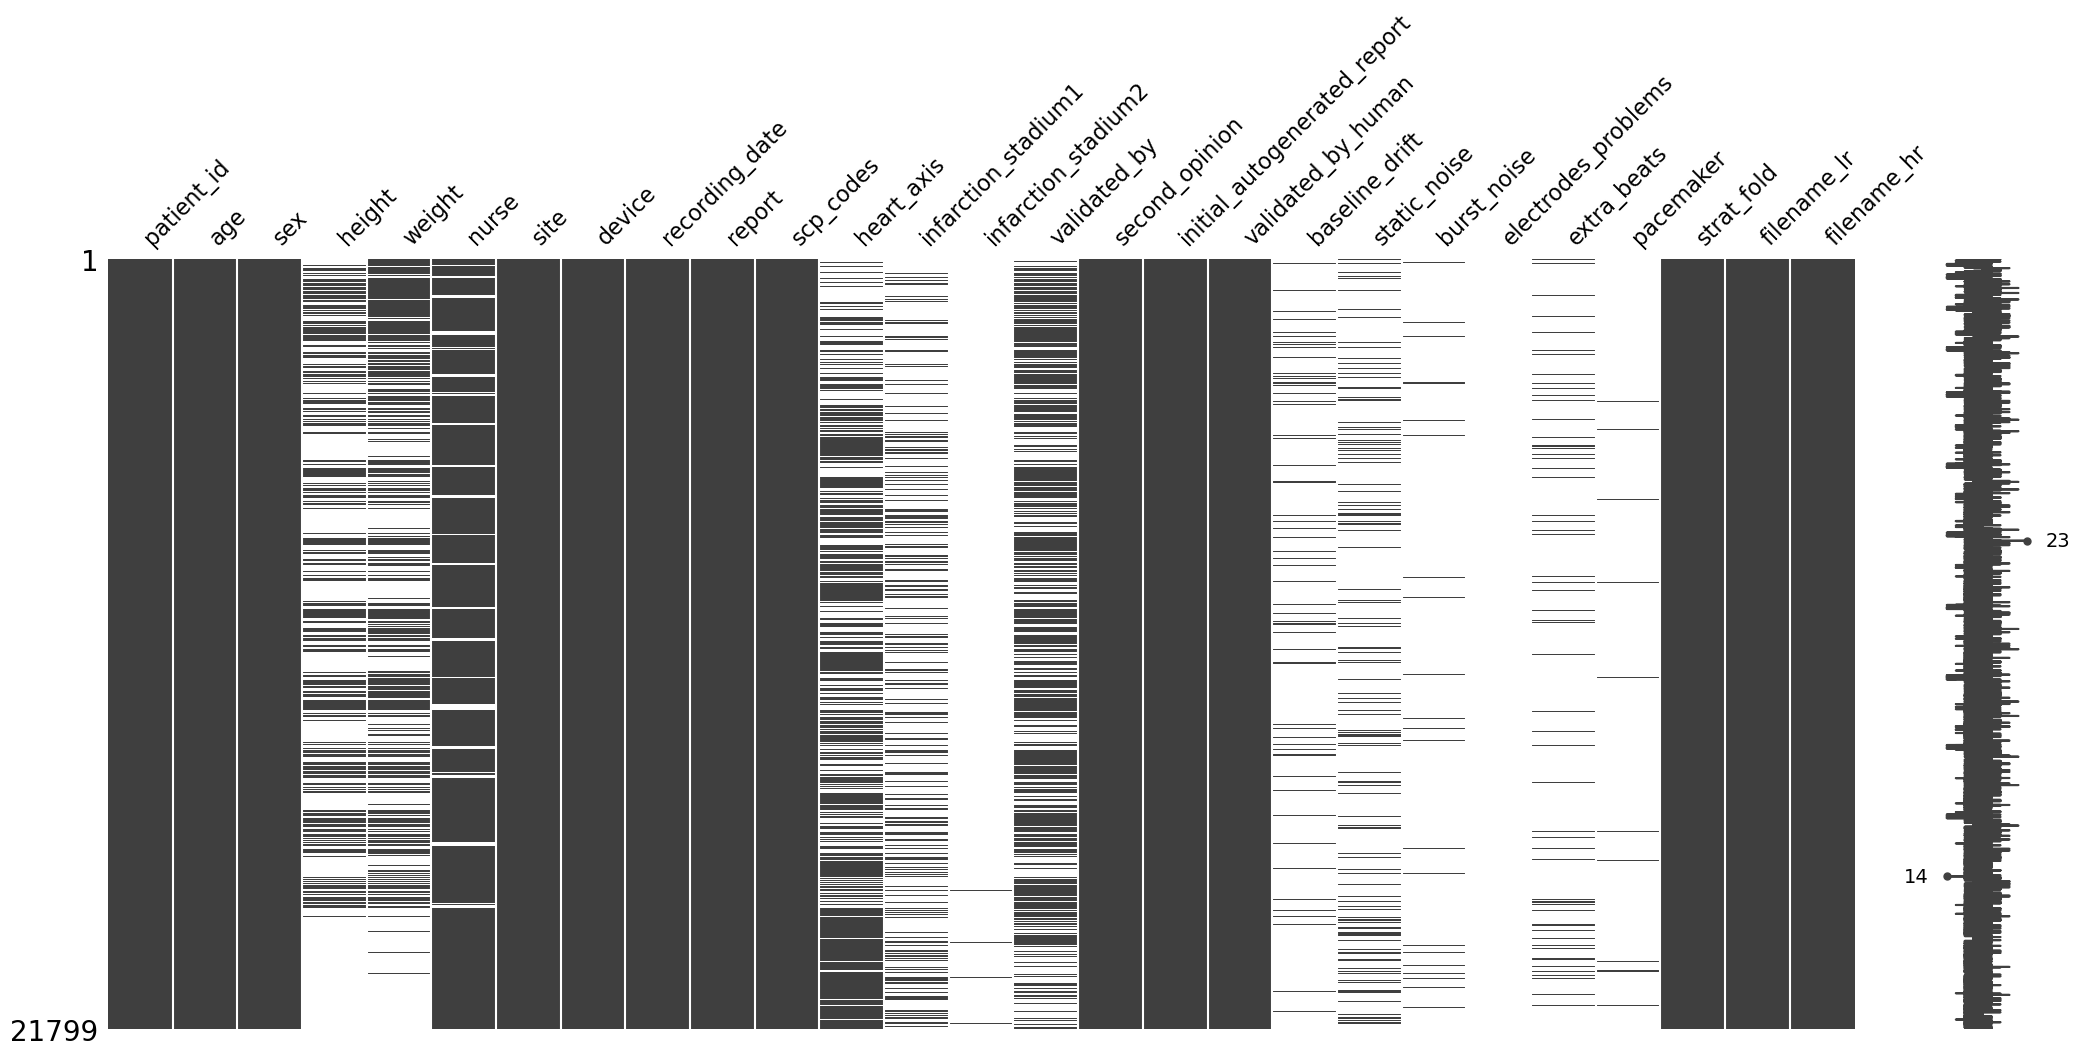

In [13]:
#Overview to see the density of each column
msno.matrix(metadata)
plt.show()

In [14]:
print(metadata['scp_codes'].value_counts()) 

scp_codes
{'NORM': 100.0, 'SR': 0.0}                                               6142
{'NORM': 80.0, 'SR': 0.0}                                                 722
{'NDT': 100.0, 'SR': 0.0}                                                 633
{'LAFB': 100.0, 'SR': 0.0}                                                277
{'PACE': 100.0}                                                           272
                                                                         ... 
{'ASMI': 100.0, 'SR': 0.0, 'ISC_': 100.0, 'LAFB': 100.0, 'LVH': 50.0}       1
{'PACE': 0.0}                                                               1
{'ISCAN': 100.0, 'IVCD': 100.0, 'STACH': 0.0}                               1
{'AFLT': 100.0, 'LVOLT': 0.0, 'SVTAC': 0.0}                                 1
{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'STACH': 0.0}                    1
Name: count, Length: 5298, dtype: int64


In [5]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

print(agg_df.shape)

(44, 12)


In [6]:
def aggregate_superclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            # only select 100% diagnosis
            if y_dic[key] == 100: 
                tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
metadata['diagnostic_superclass'] = metadata.scp_codes.apply(aggregate_superclass_diagnostic)
metadata['diagnostic_superclass_len'] = metadata['diagnostic_superclass'].apply(len)
metadata.loc[metadata.diagnostic_superclass_len >= 1, 'diagnostic_superclass']

ecg_id
1        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
6        [NORM]
          ...  
21832      [CD]
21833    [STTC]
21834    [NORM]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 17221, dtype: object

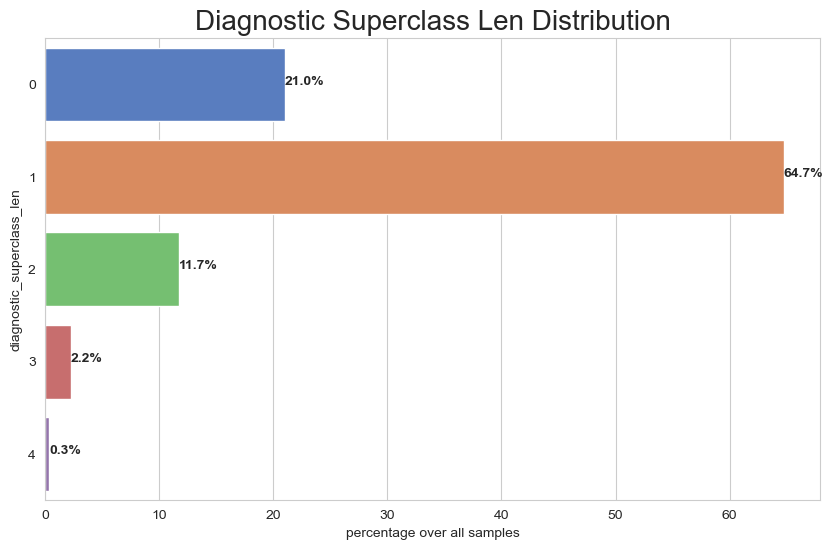

In [17]:
vc_superclass = metadata['diagnostic_superclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc_superclass.values/vc_superclass.values.sum()*100., y=vc_superclass.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Superclass Len Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnostic_superclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )


(14112, 29)


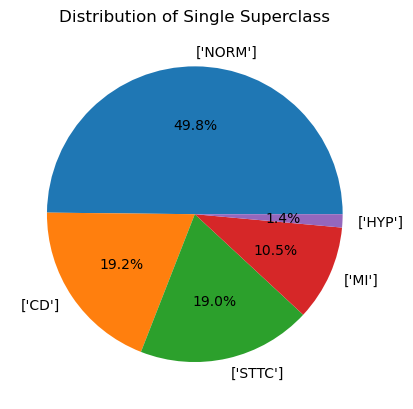

In [7]:
# show the distribution of single superclass data
single_label = metadata[metadata['diagnostic_superclass_len'] == 1]
print(single_label.shape)
vc_single = single_label['diagnostic_superclass'].value_counts()
plt.pie(vc_single, labels=vc_single.index, autopct='%1.1f%%')
plt.title('Distribution of Single Superclass')
plt.show() 

### 1.3 Metadata filtering

In [8]:
# keep the single superclass data with 'NORM', 'STTC','CD','MI'
single_label = single_label[single_label['diagnostic_superclass'].apply(lambda x: x != ['HYP'])]
single_label['diagnostic_superclass']=single_label['diagnostic_superclass'].apply(lambda x: ' '.join(x))
single_label['diagnostic_superclass']

ecg_id
1        NORM
3        NORM
4        NORM
5        NORM
6        NORM
         ... 
21832      CD
21833    STTC
21834    NORM
21836    NORM
21837    NORM
Name: diagnostic_superclass, Length: 13908, dtype: object

  diagnostic_superclass  count
0                    CD   2715
1                    MI   1476
2                  NORM   7032
3                  STTC   2685


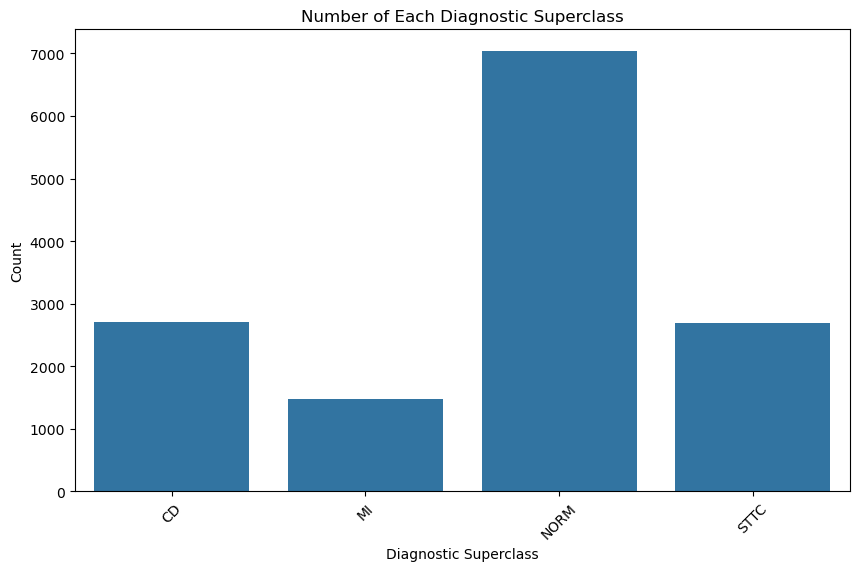

In [9]:
superclass= single_label.groupby(['diagnostic_superclass']).size().reset_index(name='count')
print(superclass)

# Plot a bar plot to visualize the number of ECG for each label using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=superclass, x='diagnostic_superclass', y='count')
plt.title('Number of Each Diagnostic Superclass')
plt.xlabel('Diagnostic Superclass')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


In [10]:
#Sample 3000 ECG signals for each class (if less than 3000, sample all of them)
samples = []
for label in single_label['diagnostic_superclass'].unique():
    # Filter the data for the current label
    _data = single_label[single_label['diagnostic_superclass'] == label]
    
    # Sample 3000 rows (or fewer if there aren't enough rows) from the current label
    _sample = _data.sample(n=min(3000, len(_data)), random_state=42)
    
    # Append the sampled data to the list
    samples.append(_sample)

# Concatenate all samples into a single DataFrame
balanced_data = pd.concat(samples).reset_index(drop=True)

balanced_data.groupby(['diagnostic_superclass']).size().reset_index(name='count')

,diagnostic_superclass,count
0,CD,2715
1,MI,1476
2,NORM,3000
3,STTC,2685


In [11]:
meta_cols =balanced_data[['age', 'sex', 'strat_fold', 'filename_lr', 'filename_hr']]
one_hot = pd.get_dummies(balanced_data['diagnostic_superclass'], columns=['diagnostic_superclass', ], prefix='', prefix_sep='', dtype=int)
ECG_meta=pd.concat([meta_cols, one_hot], axis=1)
ECG_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          9876 non-null   float64
 1   sex          9876 non-null   int64  
 2   strat_fold   9876 non-null   int64  
 3   filename_lr  9876 non-null   object 
 4   filename_hr  9876 non-null   object 
 5   CD           9876 non-null   int32  
 6   MI           9876 non-null   int32  
 7   NORM         9876 non-null   int32  
 8   STTC         9876 non-null   int32  
dtypes: float64(1), int32(4), int64(2), object(2)
memory usage: 540.2+ KB


### 1.4 Waveform signal display

In [12]:
#load ECG data according to selected metadata
X = load_raw_data(ECG_meta, sampling_rate, path)

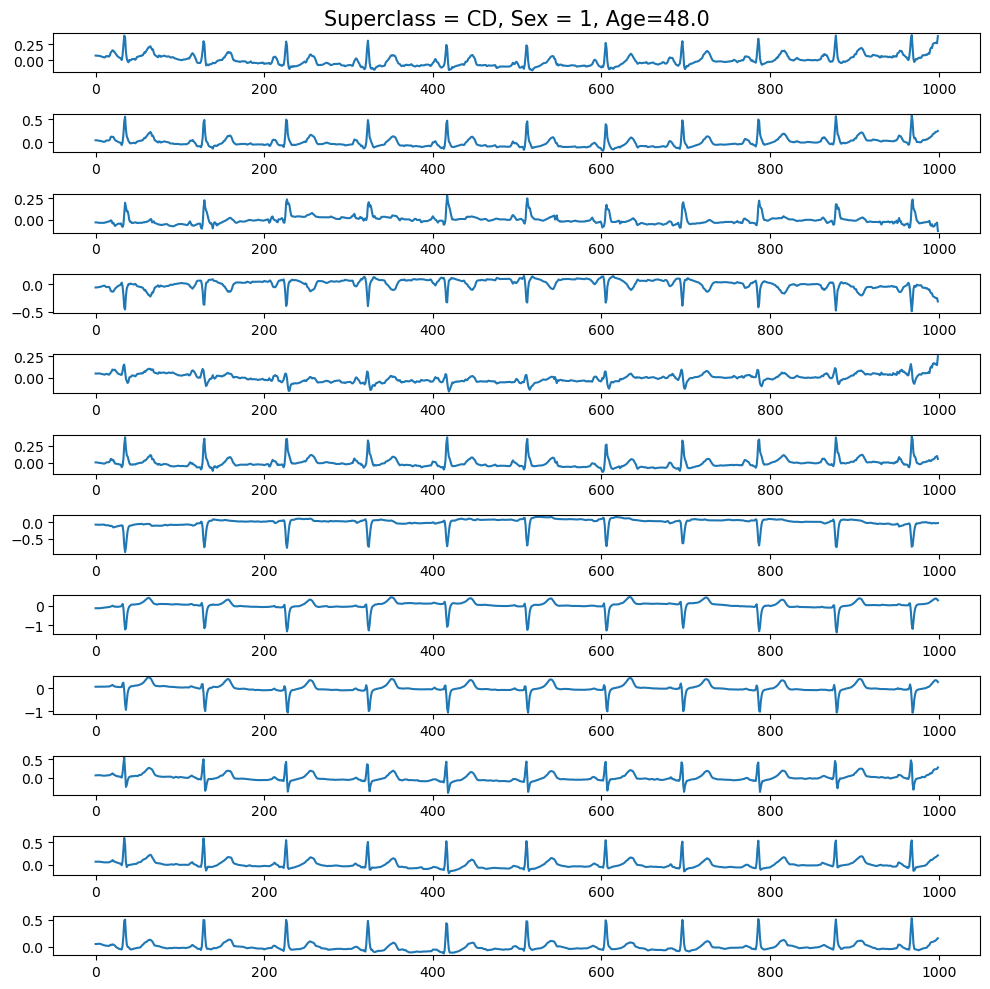

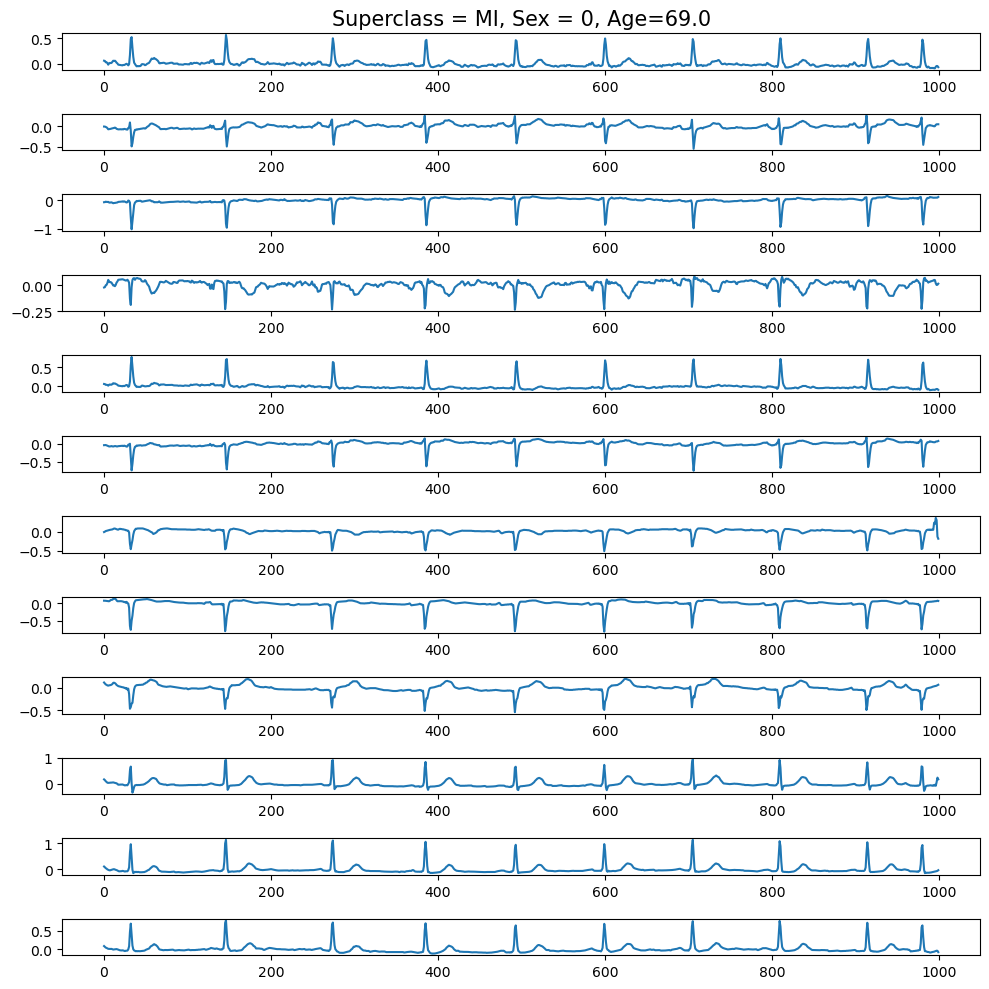

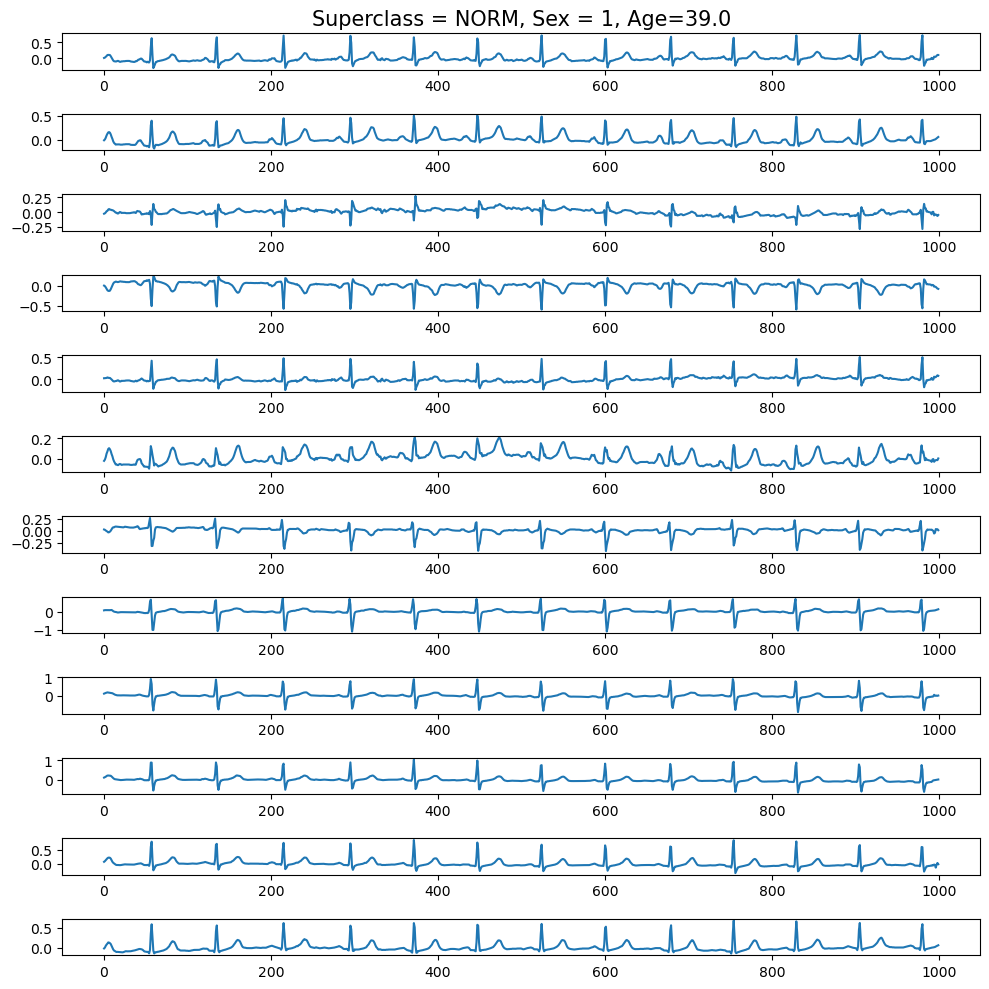

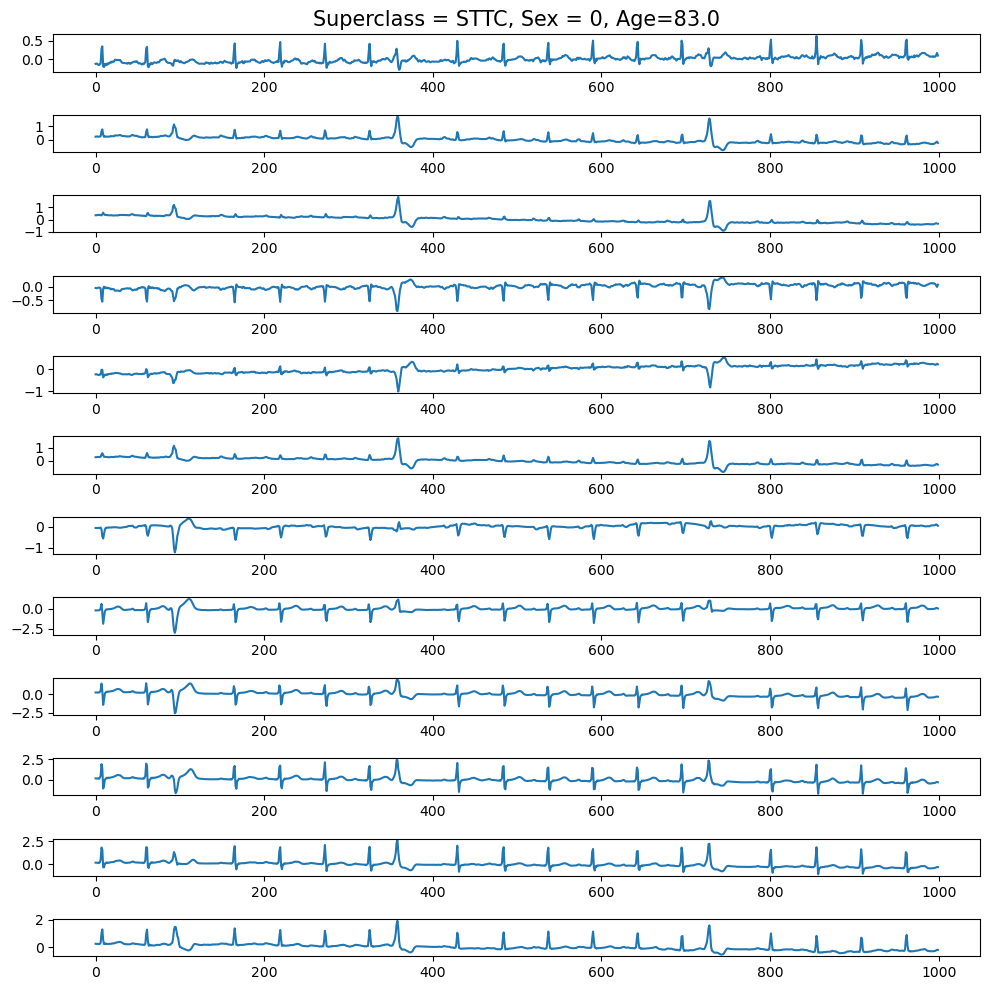

In [16]:
#show one sample data for each class
sample_num = 1

for superclass in one_hot:
    filt = ECG_meta[superclass] == 1
    y_selected = ECG_meta.loc[filt]
    x_selected = X[filt]
    
    for i in range(sample_num):
        y_ = y_selected.iloc[i]
        x_ = x_selected[i]
        
        bar, axes = plt.subplots(x_.shape[1], 1, figsize=(10,10))
        title = "Superclass = {}, Sex = {}, Age={}".format(superclass, y_['sex'], y_['age'],)
        axes[0].set_title(title, fontsize=15)
        
        for c in np.arange(x_.shape[1]):
            sns.lineplot(x=np.arange(x_.shape[0]), y=x_[:, c], ax=axes[c])
        
        plt.tight_layout()
        plt.show()

# 2. Train-Valid-Test Set Splitting

According to the source of the dataset:https://physionet.org/content/ptb-xl/1.0.1/, there are recommended stratified 10-folds, where the same patients are kept within the same folds. Moreover, 9th fold and 10th are of higher quality, which are recommeded to be used as validation set and test set.

Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.
Here, I will split compile fold 1-8 as train sets, fold 9 as validation set, and fold 10 as test set.

    strat_fold diagnostic_superclass  count
0         test                    CD    290
1         test                    MI    127
2         test                  NORM    308
3         test                  STTC    281
4        train                    CD   2141
5        train                    MI   1215
6        train                  NORM   2413
7        train                  STTC   2126
8   validation                    CD    284
9   validation                    MI    134
10  validation                  NORM    279
11  validation                  STTC    278


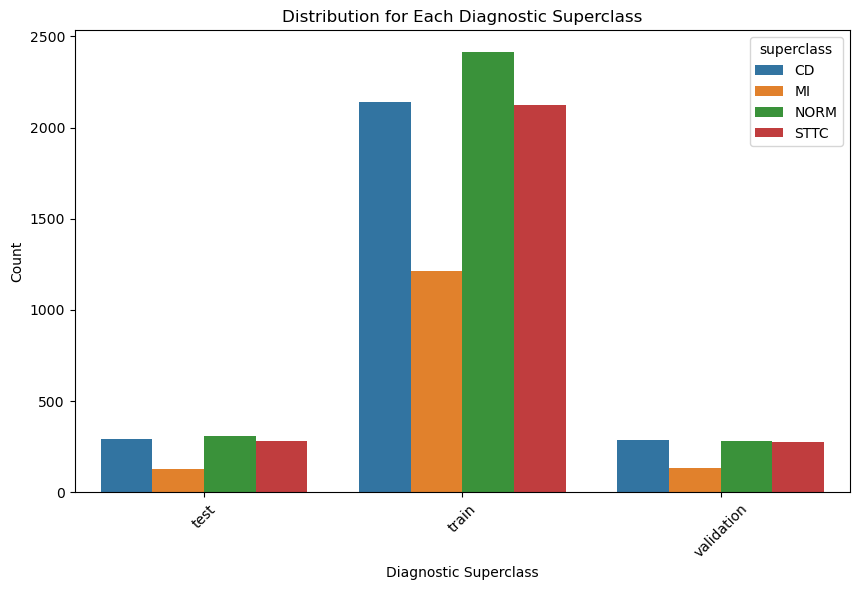

In [17]:
fold= balanced_data.copy()
fold['strat_fold'] = fold['strat_fold'].map(lambda x: 'train' if x in range(1, 9) else 'validation' if x in [9] else 'test')
fold_counts = fold.groupby(['strat_fold','diagnostic_superclass']).size().reset_index(name='count')
print(fold_counts)

# Plot a bar plot to visualize the number of ECG for each label using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=fold_counts, x='strat_fold', y='count',hue='diagnostic_superclass')
plt.title('Distribution for Each Diagnostic Superclass')
plt.xlabel('Diagnostic Superclass')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title='superclass')
plt.show()

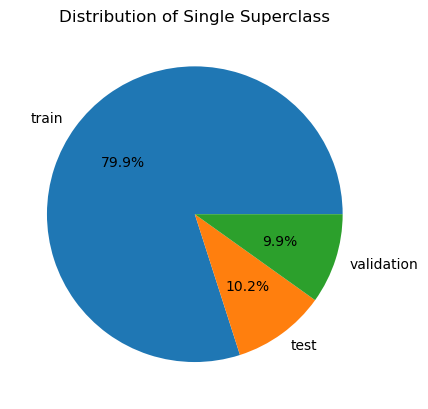

In [18]:
# show the distribution of single superclass data
vc_fold = fold['strat_fold'].value_counts()
plt.pie(vc_fold, labels=vc_fold.index, autopct='%1.1f%%')
plt.title('Distribution of Single Superclass')
plt.show() 

In [19]:
target =  ECG_meta[['NORM', 'MI', 'STTC', 'CD']]
target

,NORM,MI,STTC,CD
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
9871,0,1,0,0
9872,0,1,0,0
9873,0,1,0,0
9874,0,1,0,0


In [20]:
#training-validation-testing data split
X_train, Y_train = X[ECG_meta.strat_fold <= 8],  target[ECG_meta.strat_fold <= 8]
X_valid, Y_valid = X[ECG_meta.strat_fold == 9],  target[ECG_meta.strat_fold == 9]
X_test,  Y_test  = X[ECG_meta.strat_fold == 10], target[ECG_meta.strat_fold == 10]

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape,  Y_test.shape)


(7895, 1000, 12) (7895, 4)
(975, 1000, 12) (975, 4)
(1006, 1000, 12) (1006, 4)


In [21]:
#save data to npz file
NUMPY_DATA_FILE = 'data.npz'

save_args = {
    'X_train': X_train.astype('float32'),
    'X_valid': X_valid.astype('float32'),
    'X_test':  X_test.astype('float32'),
    'Y_train': Y_train.to_numpy().astype('float32'), 
    'Y_valid': Y_valid.to_numpy().astype('float32'),
    'Y_test':  Y_test.to_numpy().astype('float32'),
}
np.savez(NUMPY_DATA_FILE, **save_args)


# 3: Model building and training

In [23]:
%pip install tensorflow
%pip install seaborn
%pip install scikit-learn
%pip install opencv-python
%pip install imutils


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [50]:
%pip install keras-tuner

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --------- ------------------------------ 30.7/129.1 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
#import libraries
import sys
import os
import math
import numpy as np
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,LeakyReLU
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
import cv2
import time
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
thismodule = sys.modules[__name__]

with np.load('data.npz') as data:
    for k in data.keys():
        setattr(thismodule, k, data[k].astype(float))

### 3.1 1DCNN model

In [31]:
#build CNN model
def CNN():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=10, strides=3, padding='same',input_shape = (1000,12)))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling1D(pool_size=2, strides=3))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=16, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(units=7))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(layers.Dense(units=4, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', 'auc', 'precision', 'recall'])
    return model

In [33]:
#model1 summary
model1=CNN()
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 334, 32)        │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 334, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 111, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 56, 16)         │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 28, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 64)         │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         6,279 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,135 (70.84 KB)

 Trainable params: 18,039 (70.46 KB)

 Non-trainable params: 96 (384.00 B)

In [34]:
#model1 training
history1 = model1.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_valid, Y_valid))
val_loss, val_acc, val_auc, val_precision, val_recall= model1.evaluate(X_valid, Y_valid)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.4254 - auc: 0.6886 - loss: 1.2320 - precision: 0.6441 - recall: 0.1584 - val_accuracy: 0.4421 - val_auc: 0.7024 - val_loss: 1.2805 - val_precision: 0.5908 - val_recall: 0.2636
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7047 - auc: 0.8973 - loss: 0.7753 - precision: 0.7745 - recall: 0.6044 - val_accuracy: 0.5744 - val_auc: 0.8341 - val_loss: 0.9855 - val_precision: 0.6841 - val_recall: 0.4954
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7457 - auc: 0.9239 - loss: 0.6673 - precision: 0.7977 - recall: 0.6786 - val_accuracy: 0.6595 - val_auc: 0.8800 - val_loss: 0.8509 - val_precision: 0.7006 - val_recall: 0.6072
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7779 - auc: 0.9384 - loss: 0.5964 - precision: 0.8188 - recall: 0.7260 - val_accuracy: 0.7046 - val_auc: 0.9038 - val_loss: 0.7667 - val_precision: 0.7443 - val_recall: 0.6718
Epoch 5/10
124/124 ━━━━━━━━

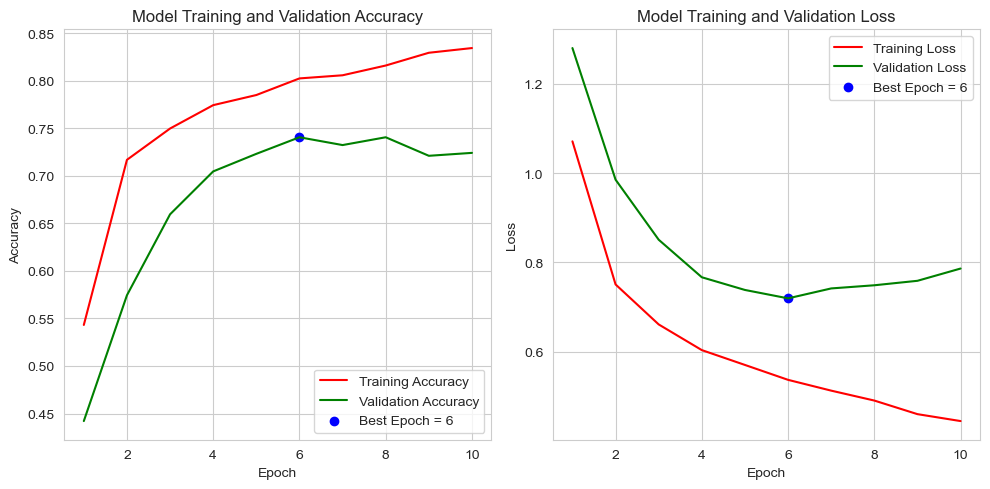

In [35]:
# Create Array for Epochs
epochs = np.arange(1,11)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history1.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history1.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(epochs, history1.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history1.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history1.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(epochs, history1.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history1.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history1.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


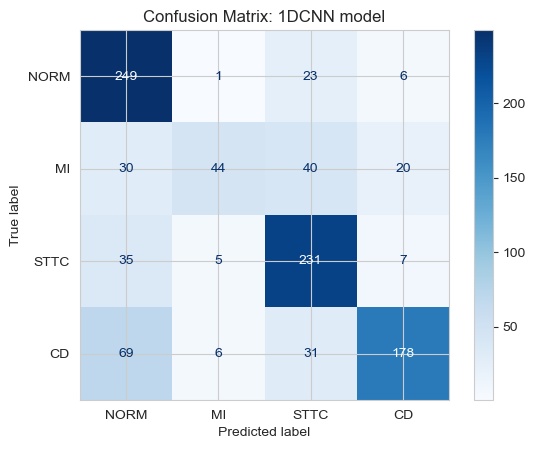

In [63]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Generate predictions
Y_pred = model1.predict(X_valid)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_valid, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_valid.argmax(axis=1), Y_pred.argmax(axis=1))

# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: 1DCNN model')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8255 - auc: 0.9572 - loss: 0.4899 - precision: 0.8468 - recall: 0.8121
Loss : 0.7366793155670166
Accuracy : 0.7475149035453796
Area under the Curve (ROC) : 0.917565107345581
Precision : 0.7664543390274048
Recall : 0.7176938652992249
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


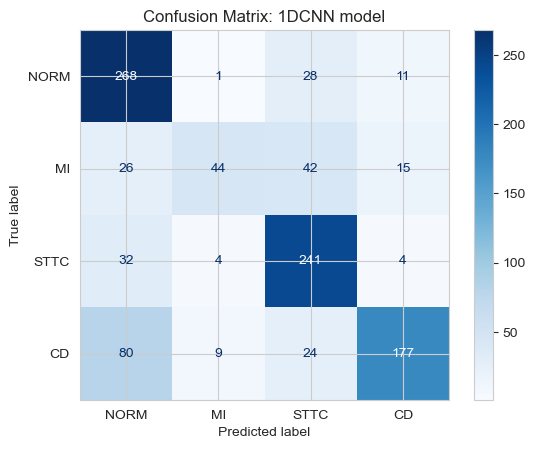

In [64]:
loss, accuracy, auc, precision, recall = model1.evaluate(X_test, Y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
# Generate predictions
Y_pred = model1.predict(X_test)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: 1DCNN model')
plt.show()

In [44]:
from sklearn.metrics import precision_recall_fscore_support


#calculate precision,recall and F1score
precision, recall, f1score, support = precision_recall_fscore_support(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# tranform the former label dictionary into list
label_list = class_names

# print precision, recall, f1score and he sample size for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1score, support)):
    label = label = label_list[i]
    print(f'{label}: Precision={p:.3f}, Recall={r:.3f}, F1 Score={f:.3f}, Support={s}')

NORM: Precision=0.660, Recall=0.870, F1 Score=0.751, Support=308
MI: Precision=0.759, Recall=0.346, F1 Score=0.476, Support=127
STTC: Precision=0.719, Recall=0.858, F1 Score=0.782, Support=281
CD: Precision=0.855, Recall=0.610, F1 Score=0.712, Support=290


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


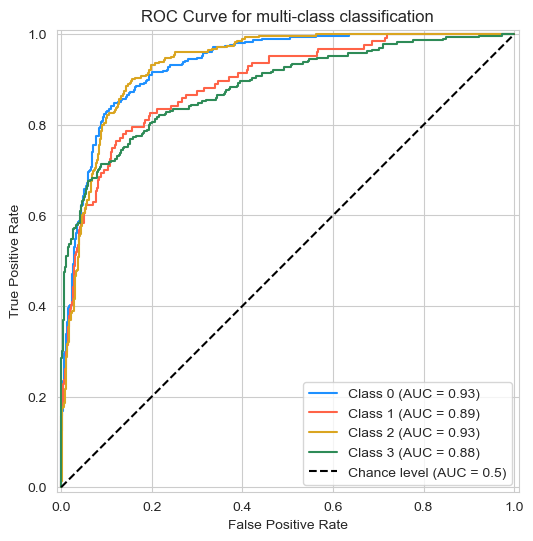

In [45]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay

# Binarize The Target By One-Hot-Encoding In A OvR Fashion
label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
n_classes = Y_test.shape[1]
y_label = Y_test
y_pred = model1.predict(X_test)

# Plot ROC and AUC for Model Validation
fig, ax = plt.subplots(figsize=(9,6))
colors = cycle(["dodgerblue", "tomato", "goldenrod", "seagreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"Class {class_id}",
        ax=ax,
        color=color,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve for multi-class classification",
)

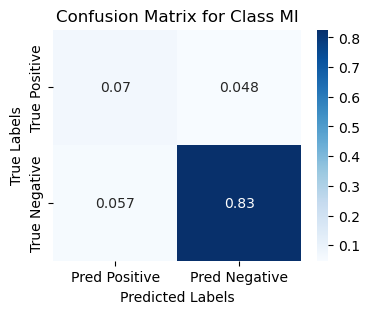

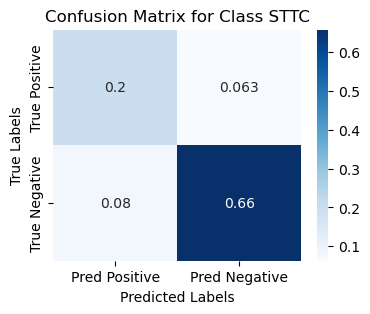

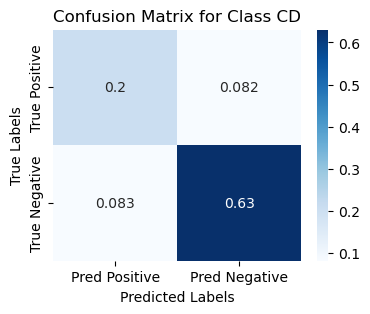

In [43]:
# heatmap visualization
def plot_class_specific_confusion_matrices(y_true, y_pred, class_names):
    num_classes = cm.shape[0]

    for i in range(1,num_classes):
        # Calculate metrics for class `i`
        TP = cm[i, i]/np.sum(cm)
        FP = (np.sum(cm[:, i]) - cm[i, i])/np.sum(cm)
        FN = (np.sum(cm[i, :]) - cm[i, i])/np.sum(cm)   
        TN = 1 - (TP + FP + FN)
        # Create a binary confusion matrix for class `i`
        class_cm = np.array([[TP, FP], [FN, TN]])

        # Labels for the binary confusion matrix
        labels = ["Pred Positive", "Pred Negative"]
        tick_labels = ["True Positive", "True Negative"]

        # Plot the binary confusion matrix
        plt.figure(figsize=(4,3))
        sns.heatmap(class_cm, annot=True, cmap='Blues',
                    xticklabels=labels, yticklabels=tick_labels)
        plt.title(f"Confusion Matrix for Class {class_names[i]}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()
plot_class_specific_confusion_matrices(y_true, y_pred, class_names)



### 3.1.1 Random search Hyperparameter tuning

In [77]:
def CNN(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Choice('filters_1', values=[16, 32, 64]), kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 10]), strides=3, padding='same',input_shape = (1000,12)))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(MaxPooling1D(pool_size=2, strides=3))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=hp.Choice('filters_2', values=[16, 32, 64]), kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]), strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=hp.Choice('filters_3', values=[32, 64, 128]), kernel_size=hp.Choice('kernel_size_3', values=[3, 5, 7]), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))
    model.add(layers.Dense(units=hp.Choice('units_1', values=[5,7,10])))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(layers.Dense(units=4, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', 'auc', 'precision', 'recall'])
    return model

In [78]:
tuner = RandomSearch(
    CNN,
    objective='val_accuracy',
    max_trials=7,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of times to train each model
    directory='hyperparameter_tuning_1DCNN',
    project_name='1dcnn_tuning'
)

Reloading Tuner from hyperparameter_tuning_1DCNN\1dcnn_tuning\tuner0.json


In [79]:
tuner.search(X_train, Y_train, 
             epochs=10, 
             validation_data=(X_valid, Y_valid), 
             batch_size=64)

# Get the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuned_model_1DCNN = tuner.get_best_models(num_models=1)[0]

# Print best hyperparameters
print(f"""
Best hyperparameters:
Filters 1: {best_hps.get('filters_1')}
Kernel Size 1: {best_hps.get('kernel_size_1')}
Filters 2: {best_hps.get('filters_2')}
Kernel Size 2: {best_hps.get('kernel_size_2')}
Filters 3: {best_hps.get('filters_3')}
Kernel Size 3: {best_hps.get('kernel_size_3')}
Dense Units 1: {best_hps.get('units_1')}
Dropout Rate: {best_hps.get('dropout_rate')}
""")
tuned_model_1DCNN.summary()



Best hyperparameters:
Filters 1: 64
Kernel Size 1: 10
Filters 2: 64
Kernel Size 2: 7
Filters 3: 64
Kernel Size 3: 5
Dense Units 1: 7
Dropout Rate: 0.3



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 334, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 334, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 111, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 56, 64)         │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         6,279 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,847 (249.40 KB)

 Trainable params: 63,591 (248.40 KB)

 Non-trainable params: 256 (1.00 KB)

In [80]:
history2 = tuned_model_1DCNN.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_valid, Y_valid))
val_loss, val_acc, val_auc, val_percision, val_recall = tuned_model_1DCNN.evaluate(X_valid, Y_valid)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.7739 - auc: 0.8814 - loss: 3.9749 - precision: 0.7747 - recall: 0.7737 - val_accuracy: 0.7005 - val_auc: 0.8507 - val_loss: 2.6909 - val_precision: 0.7034 - val_recall: 0.7005
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.7952 - auc: 0.9218 - loss: 1.2713 - precision: 0.7975 - recall: 0.7927 - val_accuracy: 0.7190 - val_auc: 0.8911 - val_loss: 1.8223 - val_precision: 0.7251 - val_recall: 0.7169
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8132 - auc: 0.9463 - loss: 0.7674 - precision: 0.8187 - recall: 0.8091 - val_accuracy: 0.7179 - val_auc: 0.8949 - val_loss: 1.3321 - val_precision: 0.7277 - val_recall: 0.7128
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8280 - auc: 0.9563 - loss: 0.5977 - precision: 0.8366 - recall: 0.8209 - val_accuracy: 0.7313 - val_auc: 0.8994 - val_loss: 1.2289 - val_precision: 0.7358 - val_recall: 0.7169
Epoch 5/10
124/124 ━━━━━━━━

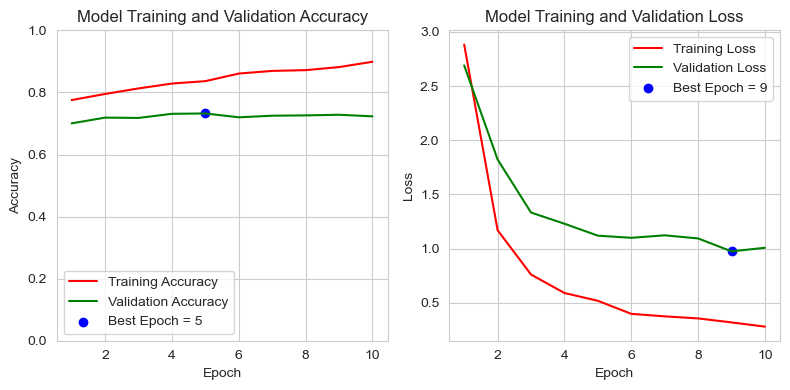

In [91]:
# Create Array for Epochs
epochs = np.arange(1,11)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history2.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history2.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(epochs, history2.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history2.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history2.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Model Training and Validation Accuracy')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(epochs, history2.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history2.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history2.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<Figure size 800x600 with 0 Axes>

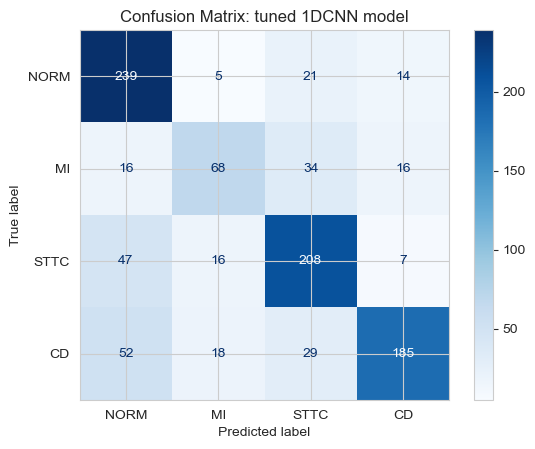

In [92]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Generate predictions
Y_pred = tuned_model_1DCNN.predict(X_valid)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_valid, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_valid.argmax(axis=1), Y_pred.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: tuned 1DCNN model')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8144 - auc: 0.9454 - loss: 0.6288 - precision: 0.8350 - recall: 0.8032
Loss : 0.9204672574996948
Accuracy : 0.7425447106361389
Area under the Curve (ROC) : 0.9099293947219849
Precision : 0.7556701302528381
Recall : 0.7286282181739807
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


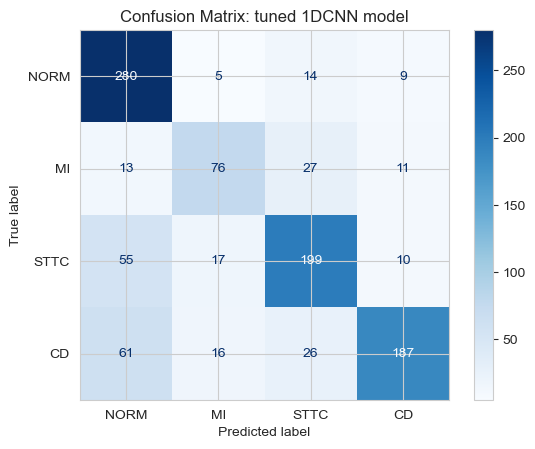

In [111]:
loss, accuracy, auc, precision, recall = tuned_model_1DCNN.evaluate(X_test, Y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
# Generate predictions
Y_pred =tuned_model_1DCNN.predict(X_test)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: tuned 1DCNN model')
plt.show()

In [112]:

from sklearn.metrics import precision_recall_fscore_support

#calculate precision,recall and F1score
precision, recall, f1score, support = precision_recall_fscore_support(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# tranform the former label dictionary into list
label_list = class_names

# print precision, recall, f1score and he sample size for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1score, support)):
    label = label = label_list[i]
    print(f'{label}: Precision={p:.3f}, Recall={r:.3f}, F1 Score={f:.3f}, Support={s}')

NORM: Precision=0.685, Recall=0.909, F1 Score=0.781, Support=308
MI: Precision=0.667, Recall=0.598, F1 Score=0.631, Support=127
STTC: Precision=0.748, Recall=0.708, F1 Score=0.728, Support=281
CD: Precision=0.862, Recall=0.645, F1 Score=0.738, Support=290


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


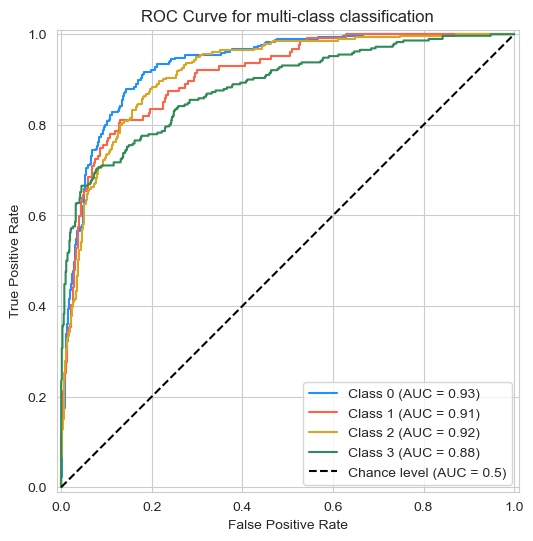

In [113]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay

# Binarize The Target By One-Hot-Encoding In A OvR Fashion
label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
n_classes = Y_test.shape[1]
y_label = Y_test
y_pred = tuned_model_1DCNN.predict(X_test)

# Plot ROC and AUC for Baseline Model Validation
fig, ax = plt.subplots(figsize=(9,6))
colors = cycle(["dodgerblue", "tomato", "goldenrod", "seagreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"Class {class_id}",
        ax=ax,
        color=color,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve for multi-class classification",
)

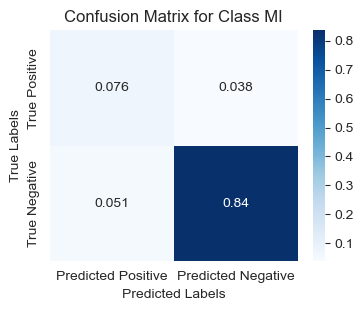

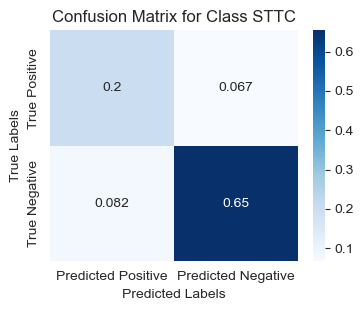

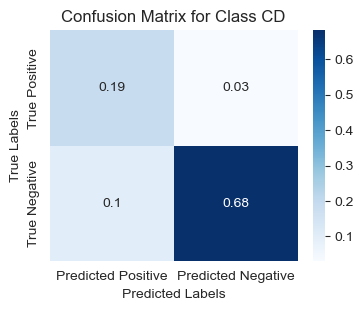

In [114]:
plot_class_specific_confusion_matrices(y_true, y_pred, class_names)

### 3.2 Bidirectional LSTM 

In [ ]:
def BiLSTM():
    model = Sequential()
    model.add(layers.Bidirectional(LSTM(64, input_shape=(1000,12))))
    model.add(Dropout(0.2))
    model.add(Dense(units=7))
    model.add(LeakyReLU())
    model.add(Dense(units=4, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', 'auc', 'precision', 'recall'])
    return model

In [104]:
model2=BiLSTM()
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [105]:
history3 = model2.fit(X_train, Y_train, epochs=5, batch_size=128, validation_data=(X_valid, Y_valid))
val_loss, val_acc, val_auc, val_percision, val_recall = model2.evaluate(X_valid, Y_valid)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 617s 10s/step - accuracy: 0.3008 - auc: 0.5731 - loss: 1.3676 - precision: 0.1718 - recall: 0.0014 - val_accuracy: 0.3344 - val_auc: 0.6144 - val_loss: 1.3373 - val_precision: 0.6000 - val_recall: 0.0062
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 638s 10s/step - accuracy: 0.3623 - auc: 0.6314 - loss: 1.3253 - precision: 0.6715 - recall: 0.0276 - val_accuracy: 0.3846 - val_auc: 0.6529 - val_loss: 1.3110 - val_precision: 0.4977 - val_recall: 0.1087
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 645s 10s/step - accuracy: 0.3885 - auc: 0.6506 - loss: 1.3084 - precision: 0.5135 - recall: 0.0877 - val_accuracy: 0.3805 - val_auc: 0.5749 - val_loss: 1.4540 - val_precision: 0.3786 - val_recall: 0.1487
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 718s 12s/step - accuracy: 0.3574 - auc: 0.6148 - loss: 1.3471 - precision: 0.5756 - recall: 0.0789 - val_accuracy: 0.2964 - val_auc: 0.5822 - val_loss: 1.3605 - val_precision: 0.6667 - val_recall: 0.0082
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━

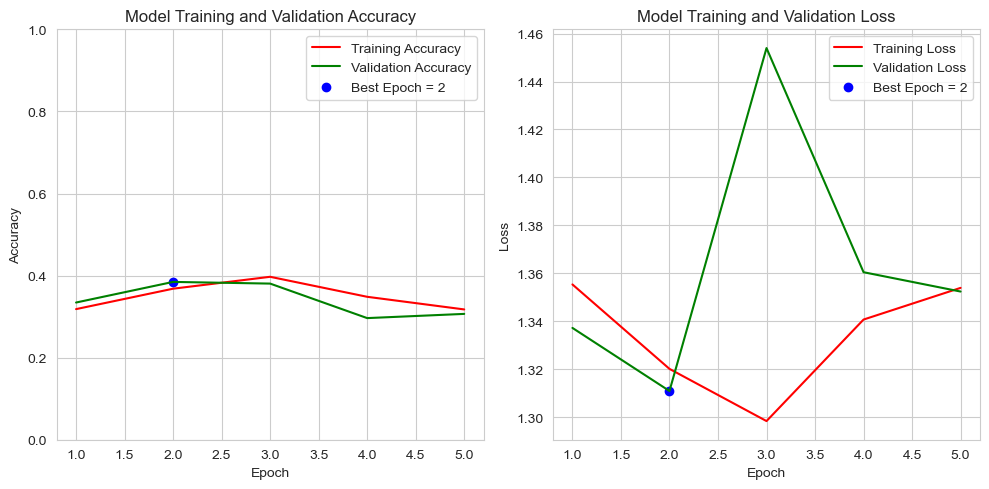

In [106]:
# Create Array for Epochs
epochs = np.arange(1,6)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history3.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history3.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(epochs, history3.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history3.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history3.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Model Training and Validation Accuracy')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(epochs, history3.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history3.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history3.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step


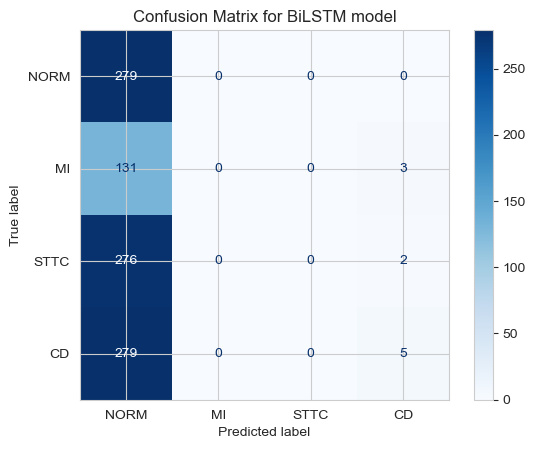

In [107]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Generate predictions
Y_pred =model2.predict(X_valid)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_valid, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_valid.argmax(axis=1), Y_pred.argmax(axis=1))

# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for BiLSTM model')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4569 - auc: 0.7542 - loss: 1.2480 - precision: 0.1812 - recall: 0.0033
Loss : 0.9204672574996948
Accuracy : 0.31610336899757385
Area under the Curve (ROC) : 0.6038281917572021
Precision : 0.5555555820465088
Recall : 0.009940357878804207
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


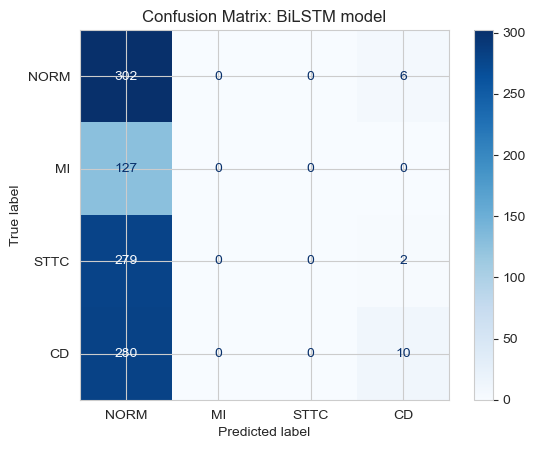

In [163]:
Loss, accuracy, auc, precision, recall = model2.evaluate(X_test, Y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
# Generate predictions
Y_pred =model2.predict(X_test)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: BiLSTM model')
plt.show()

In [117]:
from sklearn.metrics import precision_recall_fscore_support

#calculate precision,recall and F1score
precision, recall, f1score, support = precision_recall_fscore_support(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# tranform the former label dictionary into list
label_list = class_names

# print precision, recall, f1score and he sample size for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1score, support)):
    label = label = label_list[i]
    print(f'{label}: Precision={p:.3f}, Recall={r:.3f}, F1 Score={f:.3f}, Support={s}')

NORM: Precision=0.306, Recall=0.981, F1 Score=0.466, Support=308
MI: Precision=0.000, Recall=0.000, F1 Score=0.000, Support=127
STTC: Precision=0.000, Recall=0.000, F1 Score=0.000, Support=281
CD: Precision=0.556, Recall=0.034, F1 Score=0.065, Support=290


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 364ms/step


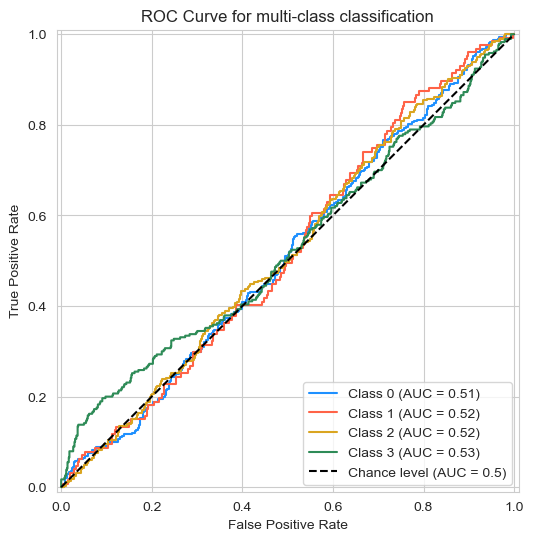

In [118]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay

# Binarize The Target By One-Hot-Encoding In A OvR Fashion
label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
n_classes = Y_test.shape[1]
y_label = Y_test
y_pred = model2.predict(X_test)

# Plot ROC and AUC for Baseline Model Validation
fig, ax = plt.subplots(figsize=(9,6))
colors = cycle(["dodgerblue", "tomato", "goldenrod", "seagreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"Class {class_id}",
        ax=ax,
        color=color,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve for multi-class classification",
)

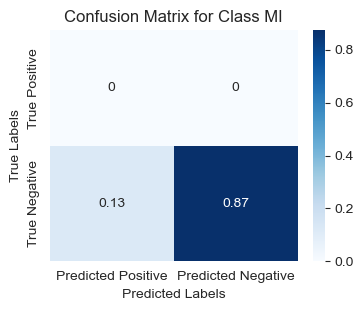

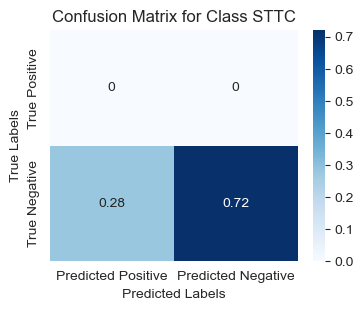

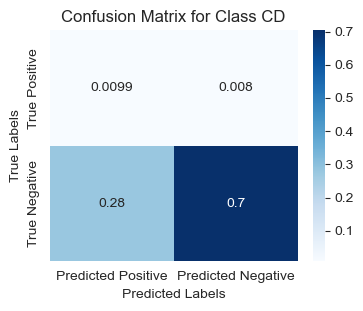

In [164]:
plot_class_specific_confusion_matrices(y_true, y_pred, class_names)

### 3.3 CNN+BiLSTM

In [135]:
def CNN_BiLSTM():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=10, strides=3, padding='same',input_shape = (1000,12)))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(MaxPooling1D(pool_size=2, strides=3))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=16, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.Bidirectional((LSTM(64))))
    model.add(Flatten())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(units=10))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(layers.Dense(units=7, activation='relu'))
    model.add(layers.Dense(units=4, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', 'auc', 'precision', 'recall'])
    return model

In [136]:
model3=CNN_BiLSTM()
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 334, 32)        │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 334, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 111, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 111, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 56, 16)         │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 28, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 28, 64)         │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │            77 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,271 (309.65 KB)

 Trainable params: 79,175 (309.28 KB)

 Non-trainable params: 96 (384.00 B)

In [137]:
history4 = model3.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_valid, Y_valid))
val_loss, val_acc, val_auc, val_percision, val_recall = model3.evaluate(X_valid, Y_valid)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - accuracy: 0.4773 - auc: 0.7337 - loss: 1.1670 - precision: 0.6142 - recall: 0.1969 - val_accuracy: 0.4133 - val_auc: 0.7012 - val_loss: 1.2552 - val_precision: 0.6005 - val_recall: 0.2451
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.7244 - auc: 0.9071 - loss: 0.7374 - precision: 0.7695 - recall: 0.6711 - val_accuracy: 0.6062 - val_auc: 0.8235 - val_loss: 1.0086 - val_precision: 0.6667 - val_recall: 0.5067
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7545 - auc: 0.9269 - loss: 0.6510 - precision: 0.7969 - recall: 0.7140 - val_accuracy: 0.6821 - val_auc: 0.8900 - val_loss: 0.8066 - val_precision: 0.7279 - val_recall: 0.6174
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7650 - auc: 0.9316 - loss: 0.6295 - precision: 0.7996 - recall: 0.7252 - val_accuracy: 0.7210 - val_auc: 0.9099 - val_loss: 0.7244 - val_precision: 0.7574 - val_recall: 0.6595
Epoch 5/10
124/124 ━━━━

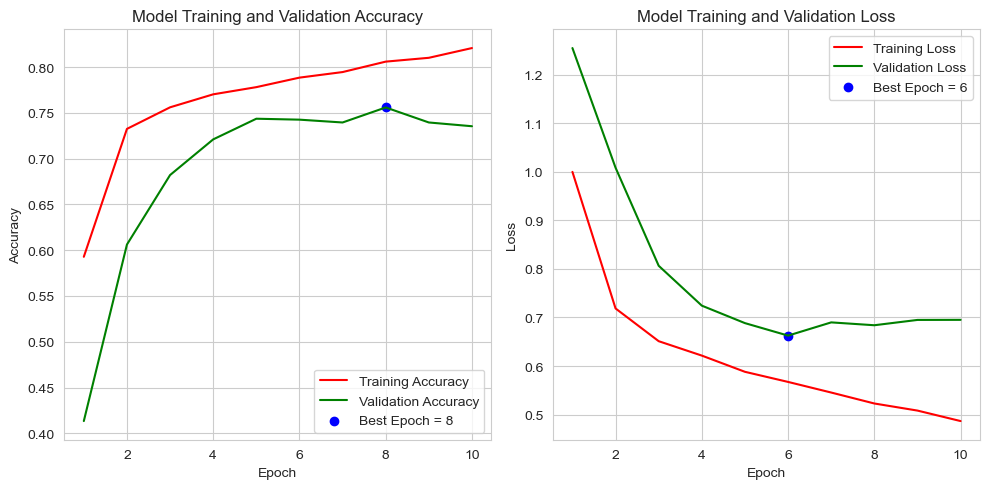

In [138]:
# Create Array for Epochs
epochs = np.arange(1,11)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history4.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history4.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(epochs, history4.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history4.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history4.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(epochs, history4.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history4.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history4.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


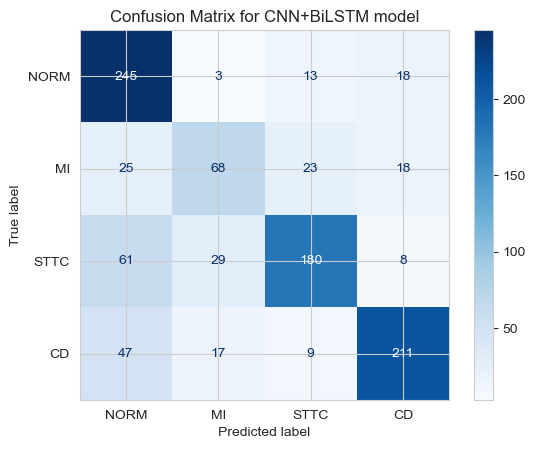

In [139]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Generate predictions
Y_pred =model3.predict(X_valid)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_valid, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_valid.argmax(axis=1), Y_pred.argmax(axis=1))

# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN+BiLSTM model')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7977 - auc: 0.9489 - loss: 0.5441 - precision: 0.8169 - recall: 0.7720
Loss : 0.9204672574996948
Accuracy : 0.7345924377441406
Area under the Curve (ROC) : 0.9225537180900574
Precision : 0.7558386325836182
Recall : 0.7077534794807434
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


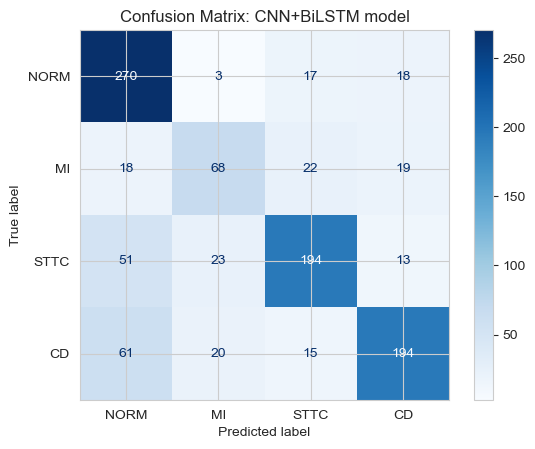

In [165]:
Loss, accuracy, auc, precision, recall = model3.evaluate(X_test, Y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
# Generate predictions
Y_pred =model3.predict(X_test)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: CNN+BiLSTM model')
plt.show()

In [143]:
from sklearn.metrics import precision_recall_fscore_support

#calculate precision,recall and F1score
precision, recall, f1score, support = precision_recall_fscore_support(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# tranform the former label dictionary into list
label_list = class_names

# print precision, recall, f1score and he sample size for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1score, support)):
    label = label = label_list[i]
    print(f'{label}: Precision={p:.3f}, Recall={r:.3f}, F1 Score={f:.3f}, Support={s}')

NORM: Precision=0.675, Recall=0.877, F1 Score=0.763, Support=308
MI: Precision=0.596, Recall=0.535, F1 Score=0.564, Support=127
STTC: Precision=0.782, Recall=0.690, F1 Score=0.733, Support=281
CD: Precision=0.795, Recall=0.669, F1 Score=0.727, Support=290


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


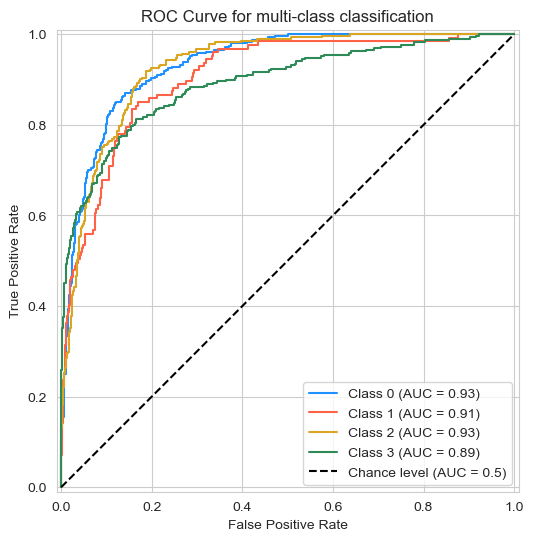

In [144]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay

# Binarize The Target By One-Hot-Encoding In A OvR Fashion
label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
n_classes = Y_test.shape[1]
y_label = Y_test
y_pred = model3.predict(X_test)

# Plot ROC and AUC for Baseline Model Validation
fig, ax = plt.subplots(figsize=(9,6))
colors = cycle(["dodgerblue", "tomato", "goldenrod", "seagreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"Class {class_id}",
        ax=ax,
        color=color,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve for multi-class classification",
)

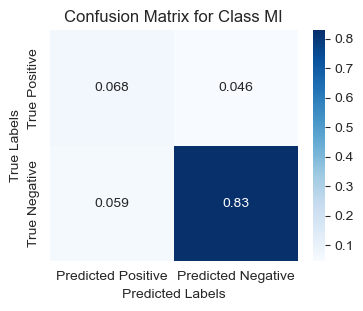

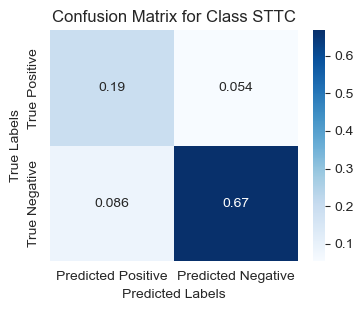

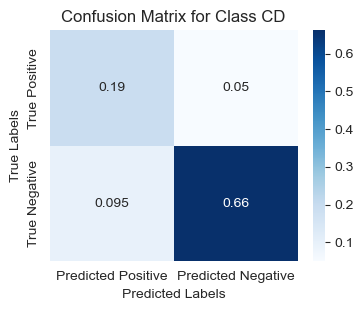

In [145]:
plot_class_specific_confusion_matrices(y_true, y_pred, class_names)

### 3.3.1 Random search hyperparameter tuning

In [128]:
def CNN_LSTM(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Choice('filters_1', values=[16, 32, 64]), kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 10]), strides=3, padding='same', input_shape = (1000,12)))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(MaxPooling1D(pool_size=2, strides=3))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=hp.Choice('filters_2', values=[16, 32, 64]), kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]), strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(filters=hp.Choice('filters_3', values=[32, 64, 128]), kernel_size=hp.Choice('kernel_size_3', values=[3, 5, 7]), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.Bidirectional(LSTM(units=hp.Choice('lstm_units', values=[20, 64, 100]))))
    model.add(Flatten())
    model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))
    model.add(layers.Dense(units=10))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(layers.Dense(units=7, activation='relu'))
    model.add(layers.Dense(units=4, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', 'auc', 'precision', 'recall'])
    return model

In [129]:
tuner = RandomSearch(
    CNN_LSTM,
    objective='val_accuracy',
    max_trials=7,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of times to train each model
    directory='hyperparameter_tuning_CNNBiLSTM',
    project_name='cnn_bilstm_tuning'
)

Reloading Tuner from hyperparameter_tuning_CNNBiLSTM\cnn_bilstm_tuning\tuner0.json


In [130]:
tuner.search(X_train, Y_train, 
             epochs=10, 
             validation_data=(X_valid, Y_valid), 
             batch_size=64)

# Get the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuned_model_CNNLSTM = tuner.get_best_models(num_models=1)[0]

# Print best hyperparameters
print(f"""
Best hyperparameters:
Filters 1: {best_hps.get('filters_1')}
Kernel Size 1: {best_hps.get('kernel_size_1')}
Filters 2: {best_hps.get('filters_2')}
Kernel Size 2: {best_hps.get('kernel_size_2')}
Filters 3: {best_hps.get('filters_3')}
Kernel Size 3: {best_hps.get('kernel_size_3')}
LSTM Units 1: {best_hps.get('lstm_units')}
Dropout Rate: {best_hps.get('dropout_rate')}
""")
tuned_model_CNNLSTM.summary()


Best hyperparameters:
Filters 1: 64
Kernel Size 1: 10
Filters 2: 16
Kernel Size 2: 5
Filters 3: 128
Kernel Size 3: 7
LSTM Units 1: 64
Dropout Rate: 0.1



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 334, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 334, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 111, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 56, 16)         │         5,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 28, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 128)        │        14,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            77 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,879 (499.53 KB)

 Trainable params: 127,719 (498.90 KB)

 Non-trainable params: 160 (640.00 B)

In [131]:
history5 = tuned_model_CNNLSTM.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_valid, Y_valid))
val_loss, val_acc, val_auc, val_percision, val_recall = tuned_model_CNNLSTM.evaluate(X_valid, Y_valid)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.8109 - auc: 0.9554 - loss: 0.5048 - precision: 0.8397 - recall: 0.7820 - val_accuracy: 0.7518 - val_auc: 0.9270 - val_loss: 0.6602 - val_precision: 0.7876 - val_recall: 0.7190
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8428 - auc: 0.9648 - loss: 0.4447 - precision: 0.8680 - recall: 0.8157 - val_accuracy: 0.7344 - val_auc: 0.9187 - val_loss: 0.7230 - val_precision: 0.7549 - val_recall: 0.7077
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8323 - auc: 0.9640 - loss: 0.4500 - precision: 0.8551 - recall: 0.8080 - val_accuracy: 0.7077 - val_auc: 0.9136 - val_loss: 0.7460 - val_precision: 0.7345 - val_recall: 0.6923
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8533 - auc: 0.9704 - loss: 0.4081 - precision: 0.8734 - recall: 0.8296 - val_accuracy: 0.7518 - val_auc: 0.9241 - val_loss: 0.6831 - val_precision: 0.7860 - val_recall: 0.7118
Epoch 5/10
124/124 ━━━━━━━━

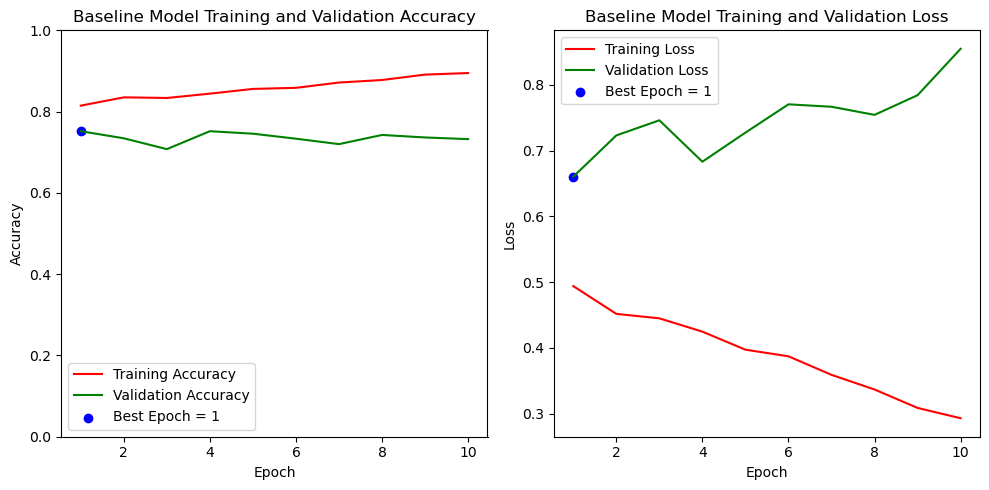

In [132]:
# Create Array for Epochs
epochs = np.arange(1,11)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history5.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history5.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(epochs, history5.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history5.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history5.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Baseline Model Training and Validation Accuracy')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(epochs, history5.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history5.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history5.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


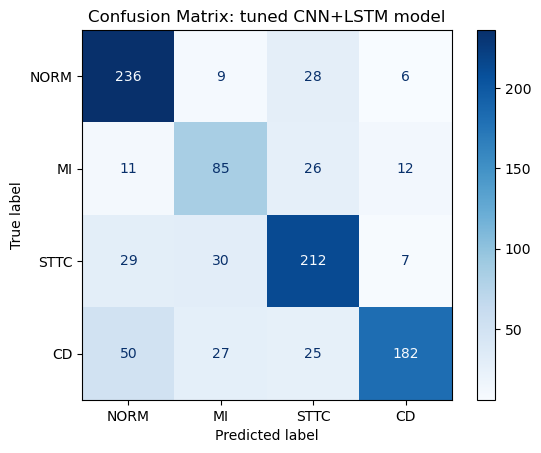

In [133]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Generate predictions
Y_pred = tuned_model_CNNLSTM.predict(X_valid)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_valid, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_valid.argmax(axis=1), Y_pred.argmax(axis=1))

# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: tuned CNN+LSTM model')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7611 - auc: 0.9364 - loss: 0.6727 - precision: 0.7760 - recall: 0.7468
Loss : 0.7827797532081604
Accuracy : 0.7196819186210632
Area under the Curve (ROC) : 0.9135318994522095
Precision : 0.7301750779151917
Recall : 0.7047713994979858
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


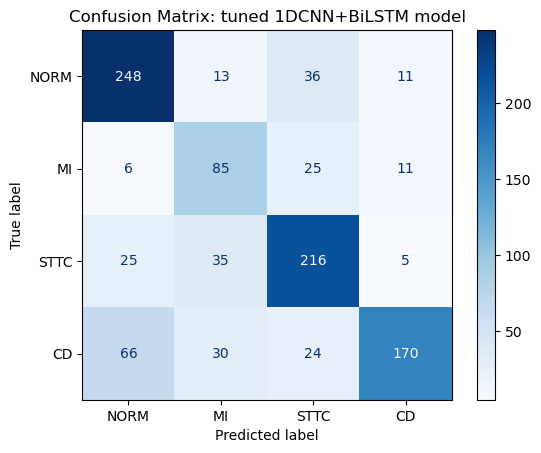

In [134]:
Loss, accuracy, auc, precision, recall = tuned_model_CNNLSTM.evaluate(X_test, Y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
# Generate predictions
Y_pred =tuned_model_CNNLSTM.predict(X_test)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: tuned 1DCNN+BiLSTM model')
plt.show()

In [135]:
from sklearn.metrics import precision_recall_fscore_support


#calculate precision,recall and F1score
precision, recall, f1score, support = precision_recall_fscore_support(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# tranform the former label dictionary into list
label_list = class_names

# print precision, recall, f1score and he sample size for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1score, support)):
    label = label = label_list[i]
    print(f'{label}: Precision={p:.3f}, Recall={r:.3f}, F1 Score={f:.3f}, Support={s}')

NORM: Precision=0.719, Recall=0.805, F1 Score=0.760, Support=308
MI: Precision=0.521, Recall=0.669, F1 Score=0.586, Support=127
STTC: Precision=0.718, Recall=0.769, F1 Score=0.742, Support=281
CD: Precision=0.863, Recall=0.586, F1 Score=0.698, Support=290


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


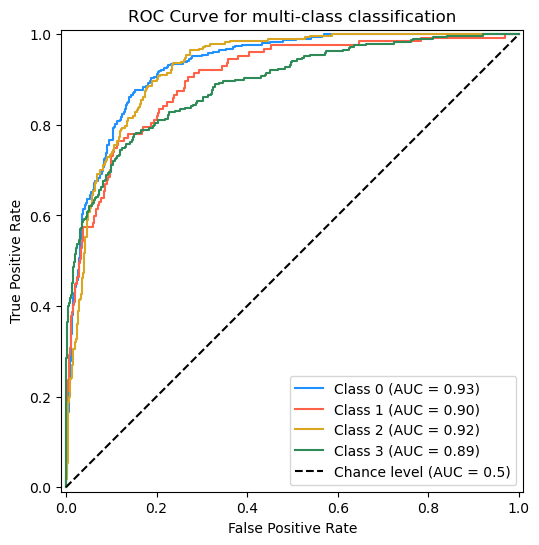

In [136]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay

# Binarize The Target By One-Hot-Encoding In A OvR Fashion
label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
n_classes = Y_test.shape[1]
y_label = Y_test
y_pred =tuned_model_CNNLSTM.predict(X_test)

# Plot ROC and AUC for Baseline Model Validation
fig, ax = plt.subplots(figsize=(9,6))
colors = cycle(["dodgerblue", "tomato", "goldenrod", "seagreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"Class {class_id}",
        ax=ax,
        color=color,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve for multi-class classification",
)

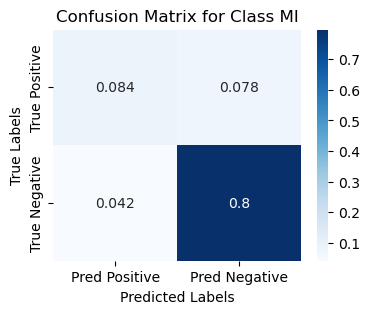

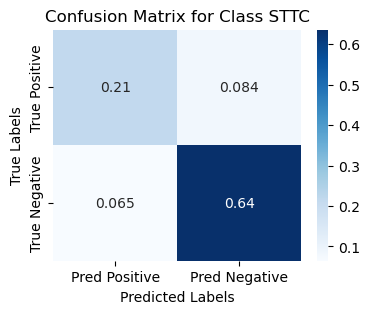

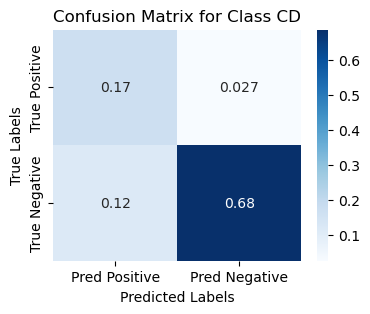

In [137]:
plot_class_specific_confusion_matrices(y_true, y_pred, class_names)

# 4. Class imbalance: SMOTE and Class Weight

### 4.1 Best performing model with SMOTE

In [26]:
from imblearn.over_sampling import SMOTE

In [27]:
# flatten the signals into a single feature vector for each sample. 
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42) #apply SMOTE to oversample the minority class. 
X_train_resampled, Y_trian_resampled = smote.fit_resample(X_train_flattened, Y_train)
# Reshape back to the original shape
X_train_resampled = X_train_resampled.reshape(-1, 1000, 12)

In [118]:
model4=tuned_model_CNNLSTM
history6 = model4.fit(X_train_resampled, Y_trian_resampled, epochs=10, batch_size=64, validation_data=(X_valid, Y_valid))
val_loss, val_acc, val_auc, val_precision, vall_recall = model4.evaluate(X_valid, Y_valid)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.8279 - auc: 0.9614 - loss: 0.4685 - precision: 0.8525 - recall: 0.7975 - val_accuracy: 0.7477 - val_auc: 0.9219 - val_loss: 0.6878 - val_precision: 0.7847 - val_recall: 0.7138
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8459 - auc: 0.9679 - loss: 0.4255 - precision: 0.8691 - recall: 0.8226 - val_accuracy: 0.7313 - val_auc: 0.9157 - val_loss: 0.7304 - val_precision: 0.7560 - val_recall: 0.7087
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8529 - auc: 0.9703 - loss: 0.4101 - precision: 0.8717 - recall: 0.8298 - val_accuracy: 0.7467 - val_auc: 0.9246 - val_loss: 0.7020 - val_precision: 0.7745 - val_recall: 0.7292
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8638 - auc: 0.9747 - loss: 0.3750 - precision: 0.8845 - recall: 0.8444 - val_accuracy: 0.7477 - val_auc: 0.9241 - val_loss: 0.6939 - val_precision: 0.7628 - val_recall: 0.7190
Epoch 5/10
151/151 ━━━━━

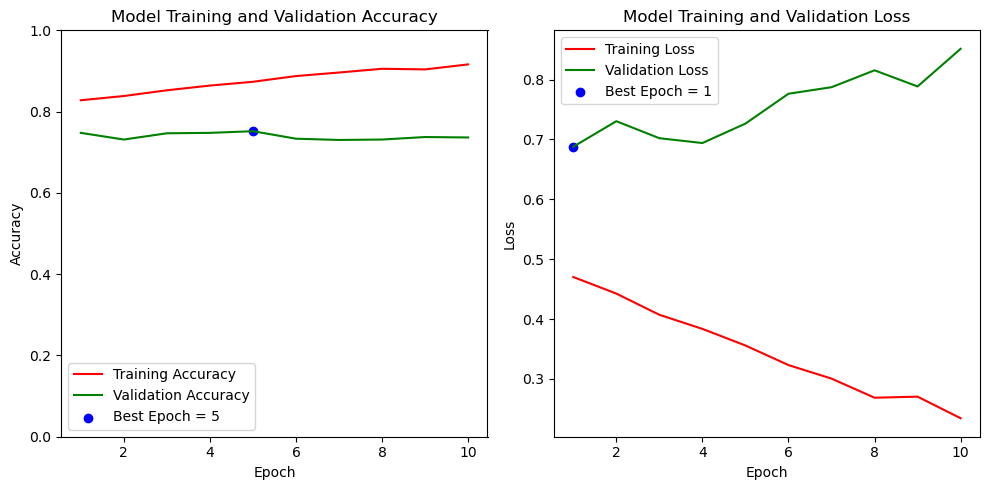

In [119]:
# Create Array for Epochs
epochs = np.arange(1,11)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history6.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history6.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(epochs, history6.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history6.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history6.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Model Training and Validation Accuracy')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(epochs, history6.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history6.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history6.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


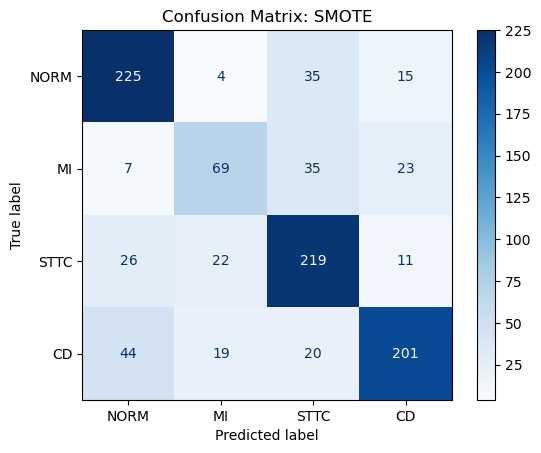

In [120]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Generate predictions
Y_pred = model4.predict(X_valid)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_valid, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_valid.argmax(axis=1), Y_pred.argmax(axis=1))

# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: SMOTE')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7850 - auc: 0.9434 - loss: 0.6174 - precision: 0.8033 - recall: 0.7778
Loss : 0.7827797532081604
Accuracy : 0.7445328235626221
Area under the Curve (ROC) : 0.9220453500747681
Precision : 0.7651905417442322
Recall : 0.7385686039924622
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


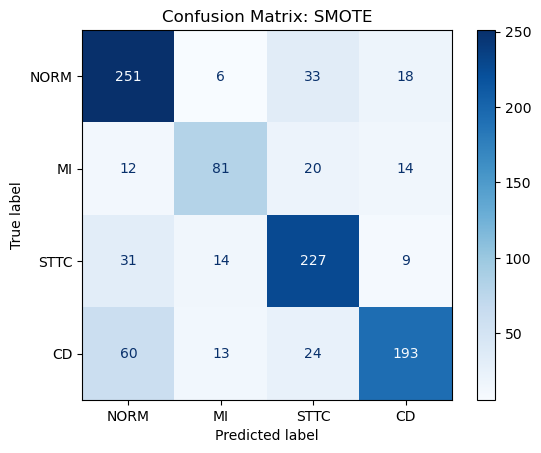

In [121]:
loss, accuracy, auc, precision, recall = model4.evaluate(X_test, Y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
# Generate predictions
Y_pred =model4.predict(X_test)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: SMOTE')
plt.show()

In [122]:
from sklearn.metrics import precision_recall_fscore_support
#calculate precision,recall and F1score
precision, recall, f1score, support = precision_recall_fscore_support(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# tranform the former label dictionary into list
label_list = class_names

# print precision, recall, f1score and he sample size for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1score, support)):
    label = label = label_list[i]
    print(f'{label}: Precision={p:.3f}, Recall={r:.3f}, F1 Score={f:.3f}, Support={s}')

NORM: Precision=0.709, Recall=0.815, F1 Score=0.758, Support=308
MI: Precision=0.711, Recall=0.638, F1 Score=0.672, Support=127
STTC: Precision=0.747, Recall=0.808, F1 Score=0.776, Support=281
CD: Precision=0.825, Recall=0.666, F1 Score=0.737, Support=290


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


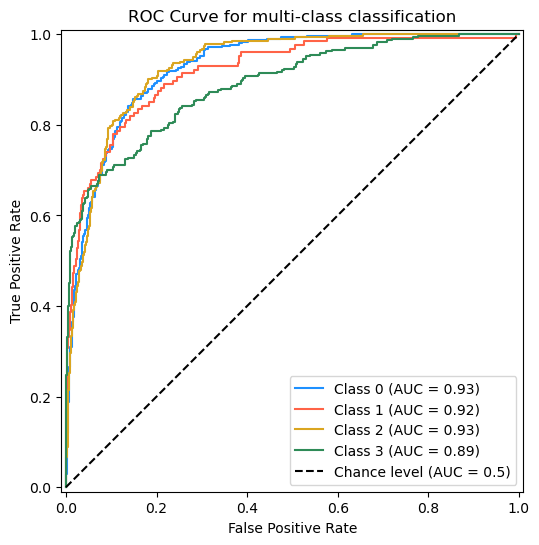

In [123]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay
# Binarize The Target By One-Hot-Encoding In A OvR Fashion
label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
n_classes = Y_test.shape[1]
y_label = Y_test
y_pred = model4.predict(X_test)

# Plot ROC and AUC for Baseline Model Validation
fig, ax = plt.subplots(figsize=(9,6))
colors = cycle(["dodgerblue", "tomato", "goldenrod", "seagreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"Class {class_id}",
        ax=ax,
        color=color,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve for multi-class classification",
)

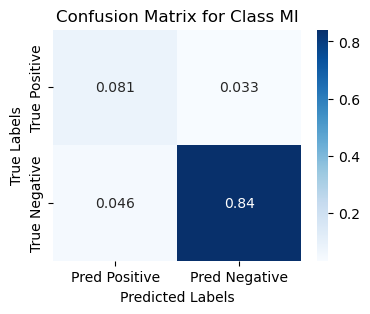

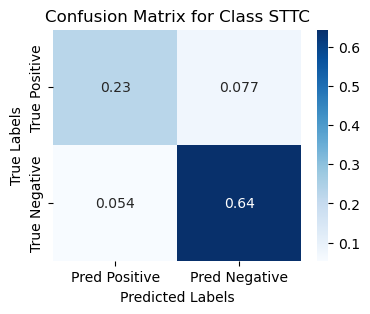

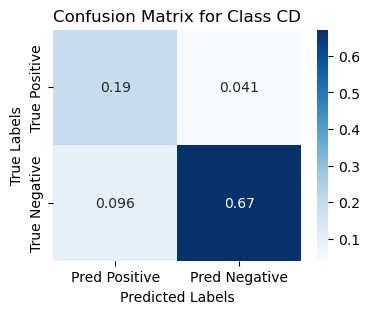

In [124]:
plot_class_specific_confusion_matrices(y_true, y_pred, class_names)

### 4.2.class weight

In [104]:
class_names = ['NORM','MI', 'STTC','CD']
column_counts = np.sum(Y_train == 1, axis=0)
row_counts = Y_train.shape[0]
NORM_weight=row_counts/(4*column_counts[0])
MI_weight=row_counts/(4*column_counts[1])
STTC_weight=row_counts/(4*column_counts[2])
CD_weight=row_counts/(4*column_counts[3])

In [105]:
class_weight={0:NORM_weight,1:MI_weight,2:STTC_weight,3:CD_weight}
print(class_weight)

{0: 0.8179651885619561, 1: 1.624485596707819, 2: 0.9283866415804327, 3: 0.9218822979915927}


In [106]:
model5=tuned_model_CNNLSTM
history7 = model5.fit(X_train, Y_train, epochs=10, batch_size=64, class_weight=class_weight, validation_data=(X_valid, Y_valid))
val_loss, val_acc, val_auc, val_percision, val_recall = model5.evaluate(X_valid, Y_valid)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.8192 - auc: 0.9581 - loss: 0.4955 - precision: 0.8473 - recall: 0.7922 - val_accuracy: 0.7405 - val_auc: 0.9203 - val_loss: 0.6836 - val_precision: 0.7764 - val_recall: 0.6944
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8446 - auc: 0.9650 - loss: 0.4464 - precision: 0.8683 - recall: 0.8125 - val_accuracy: 0.7313 - val_auc: 0.9205 - val_loss: 0.7186 - val_precision: 0.7484 - val_recall: 0.7138
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.8290 - auc: 0.9643 - loss: 0.4518 - precision: 0.8561 - recall: 0.8049 - val_accuracy: 0.7405 - val_auc: 0.9247 - val_loss: 0.6981 - val_precision: 0.7587 - val_recall: 0.7159
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.8492 - auc: 0.9671 - loss: 0.4271 - precision: 0.8653 - recall: 0.8297 - val_accuracy: 0.7354 - val_auc: 0.9188 - val_loss: 0.7296 - val_precision: 0.7588 - val_recall: 0.7097
Epoch 5/10
124/124 ━━━━━━━━

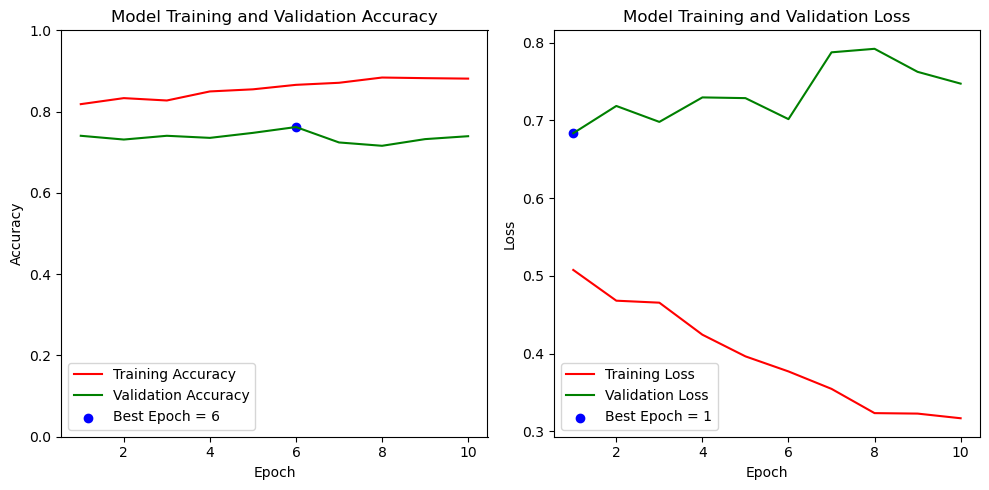

In [107]:
# Create Array for Epochs
epochs = np.arange(1,11)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history7.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history7.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(epochs, history7.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history7.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history7.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Model Training and Validation Accuracy')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(epochs, history7.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history7.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history7.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


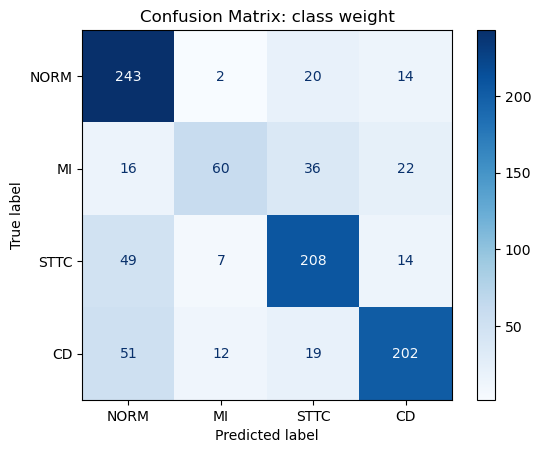

In [108]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# Generate predictions
Y_pred = model5.predict(X_valid)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_valid, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_valid.argmax(axis=1), Y_pred.argmax(axis=1))

# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: class weight')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8158 - auc: 0.9541 - loss: 0.5140 - precision: 0.8388 - recall: 0.7986
Loss : 0.7145334482192993
Accuracy : 0.7514910697937012
Area under the Curve (ROC) : 0.9262176752090454
Precision : 0.7734864354133606
Recall : 0.736580491065979
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


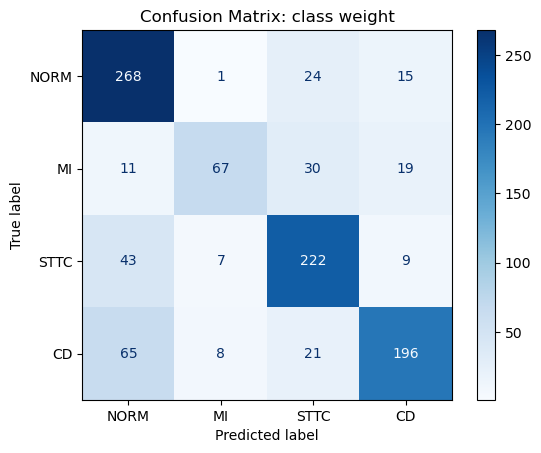

In [110]:
loss, accuracy, auc, precision, recall = model5.evaluate(X_test, Y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
# Generate predictions
Y_pred = model5.predict(X_test)
Y_pred = (Y_pred > 0.5) # Assuming one-hot encoded labels
y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
class_names = ['NORM','MI', 'STTC','CD']
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: class weight')
plt.show()

In [111]:
from sklearn.metrics import precision_recall_fscore_support

#calculate precision,recall and F1score
precision, recall, f1score, support = precision_recall_fscore_support(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# tranform the former label dictionary into list
label_list = class_names

# print precision, recall, f1score and he sample size for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1score, support)):
    label = label = label_list[i]
    print(f'{label}: Precision={p:.3f}, Recall={r:.3f}, F1 Score={f:.3f}, Support={s}')

NORM: Precision=0.693, Recall=0.870, F1 Score=0.771, Support=308
MI: Precision=0.807, Recall=0.528, F1 Score=0.638, Support=127
STTC: Precision=0.747, Recall=0.790, F1 Score=0.768, Support=281
CD: Precision=0.820, Recall=0.676, F1 Score=0.741, Support=290


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


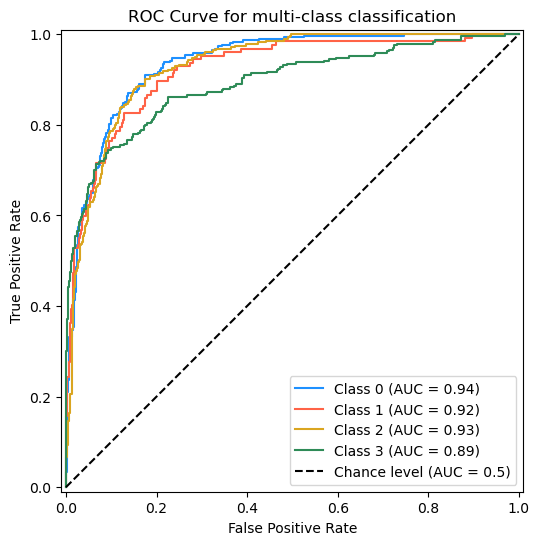

In [112]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay
# Binarize The Target By One-Hot-Encoding In A OvR Fashion
label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
n_classes = Y_test.shape[1]
y_label = Y_test
y_pred = model5.predict(X_test)

# Plot ROC and AUC for Baseline Model Validation
fig, ax = plt.subplots(figsize=(9, 6))
colors = cycle(["dodgerblue", "tomato", "goldenrod", "seagreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"Class {class_id}",
        ax=ax,
        color=color,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve for multi-class classification",
)

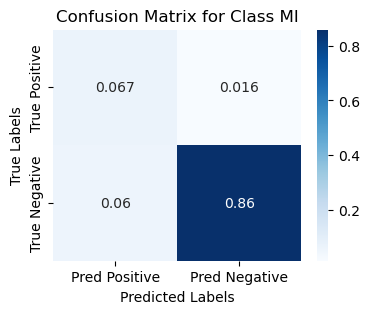

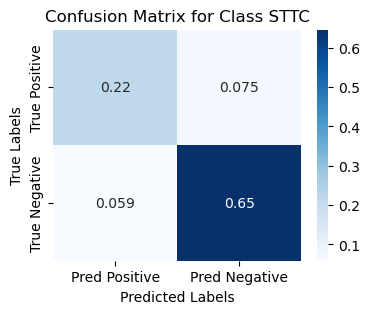

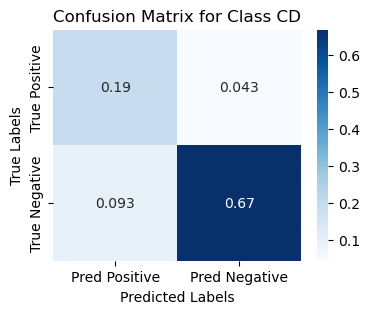

In [113]:
plot_class_specific_confusion_matrices(y_true, y_pred, class_names)